In [2]:
import os
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import cv2  # For LAB conversion

# Folder where your images are stored
image_folder = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train"

In [3]:
class_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]

print(f"📁 Total class folders: {len(class_folders)}\n")
print("🔹 Sample class folders:", class_folders[:10])

📁 Total class folders: 1000

🔹 Sample class folders: ['n01531178', 'n02412080', 'n02098413', 'n01797886', 'n04589890', 'n02437312', 'n03976657', 'n07716358', 'n03461385', 'n07753592']


In [4]:
from PIL import Image
import matplotlib.pyplot as plt

In [1]:
sample_class = class_folders[0]
sample_class_path = os.path.join(image_folder, sample_class)

# Step 3: List images in that folder
image_files = os.listdir(sample_class_path)
sample_image_path = os.path.join(sample_class_path, image_files[0])

# Step 4: Open and display image
img = Image.open(sample_image_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title(f"Class: {sample_class} | Image: {image_files[0]}")
plt.show()

NameError: name 'class_folders' is not defined

In [57]:
subset_class_ids = [
    "n01440764", "n01491361", "n01498041", "n01514859", "n01530575", "n01616318", "n01622779", "n01629819", "n01641577", "n01664065",
    "n01729322", "n01734418", "n01742172", "n01774750", "n01795545", "n01806143", "n01833805", "n01882714", "n01914609", "n01945685",
    "n01978455", "n01985128", "n02002556", "n02006656", "n02011460", "n02058221", "n02071294", "n02085782", "n02088466", "n02099601",
    "n02100583", "n02104029", "n02106550", "n02110063", "n02110958", "n02112137", "n02113023", "n02113799", "n02123045", "n02128757",
    "n02132136", "n02165456", "n02190166", "n02206856", "n02226429", "n02233338", "n02256656", "n02279972", "n02317335", "n02346627",
    "n02364673", "n02391049", "n02395406", "n02403003", "n02412080", "n02415577", "n02423022", "n02437312", "n02480495", "n02504458",
    "n02509815", "n02640242", "n02692877", "n02708093", "n02786058", "n02795169", "n02814533", "n02823428", "n02837789", "n02879718",
    "n02951358", "n02966193", "n03014705", "n03047690", "n03085013", "n03100240", "n03126707", "n03160309", "n03179701", "n03255030",
    "n03272010", "n03314780", "n03379051", "n03417042", "n03424325", "n03444034", "n03478589", "n03494278", "n03584829", "n03633091",
    "n03666591", "n03770439", "n03793489", "n03814639", "n03888257", "n03933933", "n03976657", "n04037443", "n04118538", "n04552348"
]

In [6]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
from skimage.color import rgb2lab

class LabColorizationTransform:
    def __init__(self, image_size=224):
        self.base_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(image_size),
        ])
        self.to_tensor = transforms.ToTensor()
        self.image_size = image_size

    def __call__(self, img):
        img = self.base_transform(img)
        img_np = np.array(img) / 255.0  # Normalize to [0, 1]
        
        lab = rgb2lab(img_np).astype("float32")
        L = lab[:, :, 0:1] / 50.0 - 1.0    # Normalize to [-1, 1]
        ab = lab[:, :, 1:] / 128.0        # Normalize to [-1, 1]

        L = torch.from_numpy(L).permute(2, 0, 1)
        ab = torch.from_numpy(ab).permute(2, 0, 1)
        return L, ab


In [13]:
def is_valid_file(path):
    class_dir = os.path.basename(os.path.dirname(path))
    return class_dir in subset_class_ids

In [24]:
from torch.utils.data import Dataset
from PIL import Image
import os
import glob

class FilteredImageDataset(Dataset):
    def __init__(self, root, class_ids, transform=None):
        self.samples = []
        self.transform = transform

        for class_id in class_ids:
            class_dir = os.path.join(root, class_id)
            if not os.path.isdir(class_dir):
                continue
            image_files = glob.glob(os.path.join(class_dir, '*.JPEG'))
            self.samples.extend([(path, class_id) for path in image_files])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, class_id = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            return self.transform(image)
        return image


In [58]:
transform = LabColorizationTransform(image_size=224)
imagenet_train_path = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train"

train_dataset = FilteredImageDataset(
    root=imagenet_train_path,
    class_ids=subset_class_ids,
    transform=transform
)

In [61]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

In [60]:
len(train_dataset)

129197

In [36]:
import torch.nn as nn

class ColorizationAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 112x112
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 56x56
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 28x28
            nn.ReLU(),
        )

        # Decoder: Upsample to original size and predict ab channels
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),    # 224x224
            nn.Tanh(),  # Output ab in [-1, 1]
        )


    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [62]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ColorizationAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()  # Make sure model is in training mode

    epoch_loss = 0.0
    for L, ab in train_loader:
        L, ab = L.to(device), ab.to(device)  # Move input and target to GPU

        pred_ab = model(L)
        loss = F.mse_loss(pred_ab, ab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")


Epoch 1 | Avg Loss: 0.0139
Epoch 2 | Avg Loss: 0.0134
Epoch 3 | Avg Loss: 0.0132
Epoch 4 | Avg Loss: 0.0131
Epoch 5 | Avg Loss: 0.0131
Epoch 6 | Avg Loss: 0.0130
Epoch 7 | Avg Loss: 0.0129
Epoch 8 | Avg Loss: 0.0129
Epoch 9 | Avg Loss: 0.0129
Epoch 10 | Avg Loss: 0.0128


In [ ]:
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
import numpy as np
import torch

def visualize_colorization(model, dataset, device='cuda', idx=0):
    model.eval()

    with torch.no_grad():
        # Get one sample (L, ab) pair from the dataset
        L, ab_gt = dataset[idx]  # L: (1, H, W), ab: (2, H, W)

        # Prepare input for model
        L_input = L.unsqueeze(0).to(device)  # Shape: (1, 1, H, W)

        # Model prediction
        pred_ab = model(L_input).cpu().squeeze(0)  # Shape: (2, H, W)

        # Convert tensors to numpy and denormalize
        L_np = (L.squeeze().cpu().numpy() + 1.0) * 50.0           # L channel in [0,100]
        ab_pred_np = pred_ab.numpy() * 128.0                      # Predicted ab in [-128,128]
        ab_gt_np = ab_gt.numpy() * 128.0                          # Ground truth ab in [-128,128]

        # Convert model prediction to RGB
        lab_pred = np.zeros((224, 224, 3), dtype=np.float32)
        lab_pred[:, :, 0] = L_np
        lab_pred[:, :, 1:] = ab_pred_np.transpose(1, 2, 0)
        rgb_pred = lab2rgb(lab_pred)

        # Convert ground truth to RGB
        lab_gt = np.zeros((224, 224, 3), dtype=np.float32)
        lab_gt[:, :, 0] = L_np
        lab_gt[:, :, 1:] = ab_gt_np.transpose(1, 2, 0)
        rgb_gt = lab2rgb(lab_gt)

        # Plot both images
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Ground Truth Color")
        plt.imshow(rgb_gt)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Predicted Color")
        plt.imshow(rgb_pred)
        plt.axis('off')

        plt.tight_layout()
        plt.show()


In [71]:
# Save both the model architecture and optimizer state (recommended)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'colorization_model.pth')


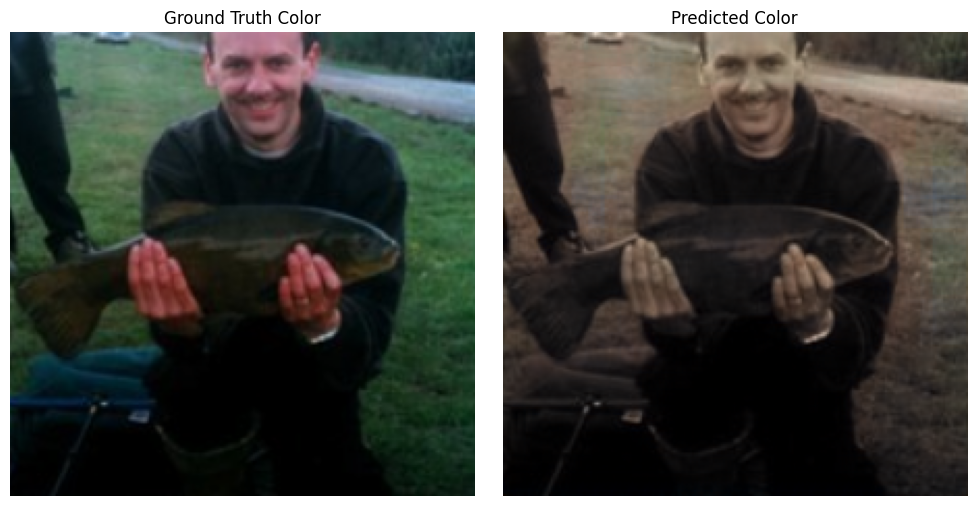

In [70]:
visualize_colorization(model, train_dataset, device=device, idx=115)